# Regression Challenge

Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.

In this challenge, you will use a dataset of real estate sales transactions to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters.

> **Citation**: The data used in this exercise originates from the following study:
>
> *Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.*
>
> It was obtained from the UCI dataset repository (Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository]([http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science).

## Review the data

Run the following cell to load the data and view the first few rows.

In [1]:
import pandas as pd

# load the training dataset
data = pd.read_csv('data/real_estate.csv')
data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


The data consists of the following variables:

- **transaction_date** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age** - the house age (in years)
- **transit_distance** - the distance to the nearest light rail station (in meters)
- **local_convenience_stores** - the number of convenience stores within walking distance
- **latitude** - the geographic coordinate, latitude
- **longitude** - the geographic coordinate, longitude
- **price_per_unit** house price of unit area (3.3 square meters)

## Train a Regression Model

Your challenge is to explore and prepare the data, identify predictive features that will help predict the **price_per_unit** label, and train a regression model that achieves the lowest Root Mean Square Error (RMSE) you can achieve (which must be less than **7**) when evaluated against a test subset of data.

Add markdown and code cells as required to create your solution.

### View the label distribution

C:\Users\farza\AppData\Local\Temp\ipykernel_5484\1322689860.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


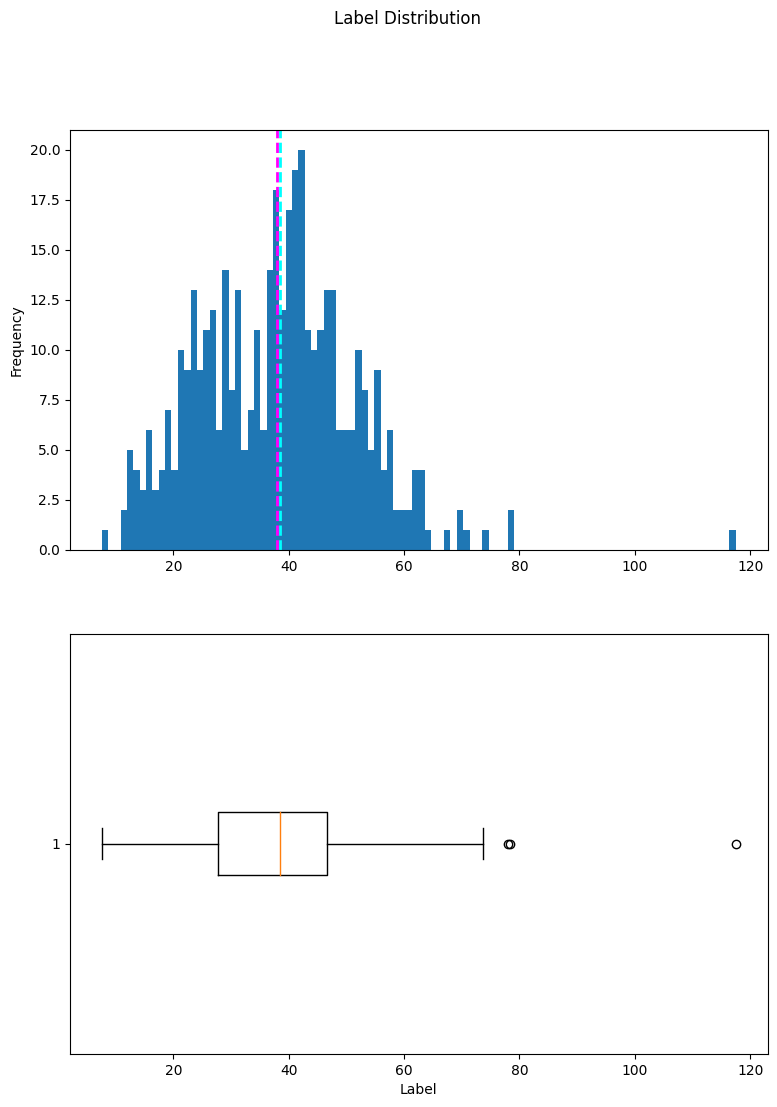

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Get the label column
label = data[data.columns[-1]]

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Label')

# Add a title to the Figure
fig.suptitle('Label Distribution')

# Show the figure
fig.show()


### Remove outliers

C:\Users\farza\AppData\Local\Temp\ipykernel_5484\2477398891.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


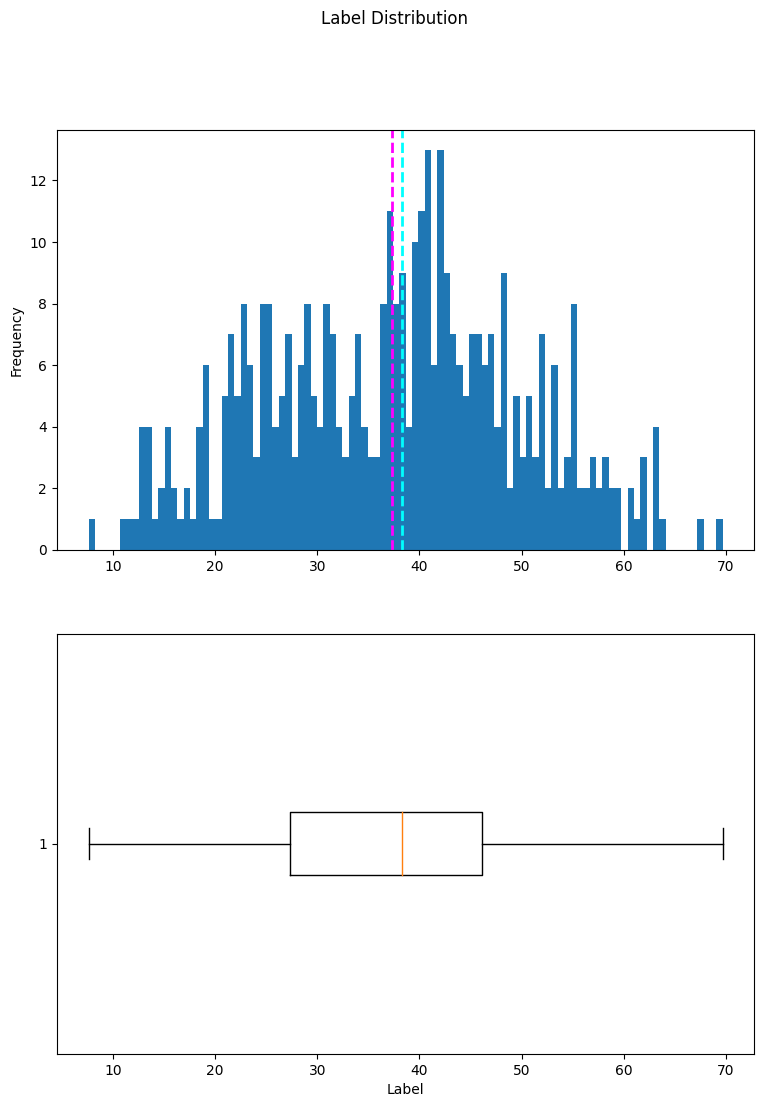

In [3]:
data = data[data['price_per_unit']<70]
# Get the label column
label = data[data.columns[-1]]

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Label')

# Add a title to the Figure
fig.suptitle('Label Distribution')

# Show the figure
fig.show()

### View numeric correlations

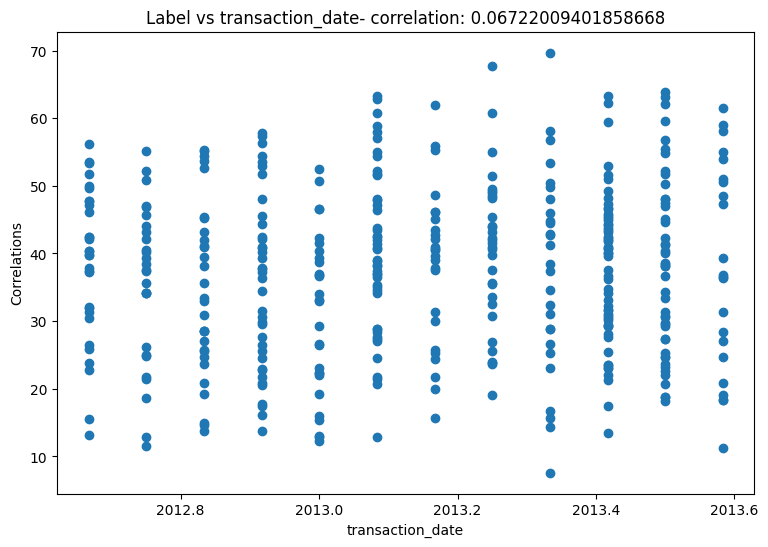

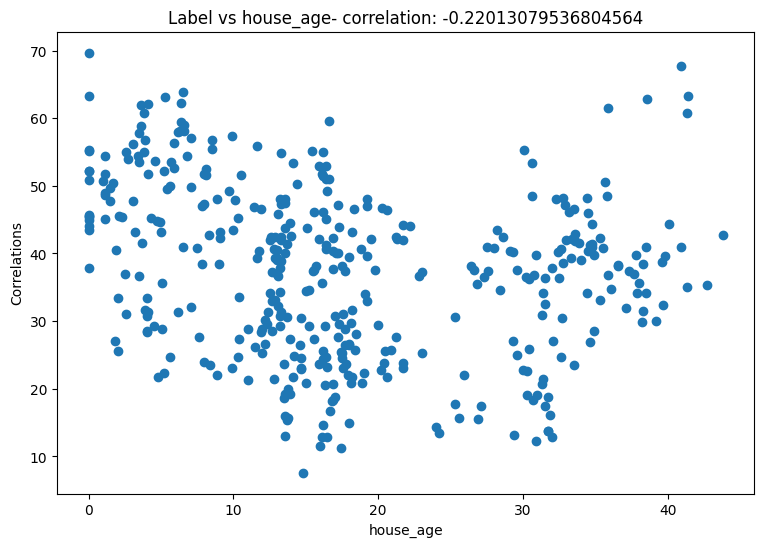

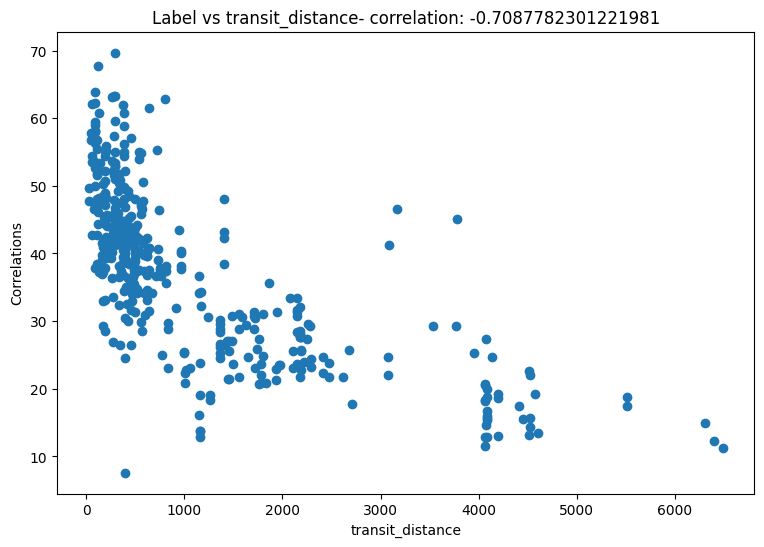

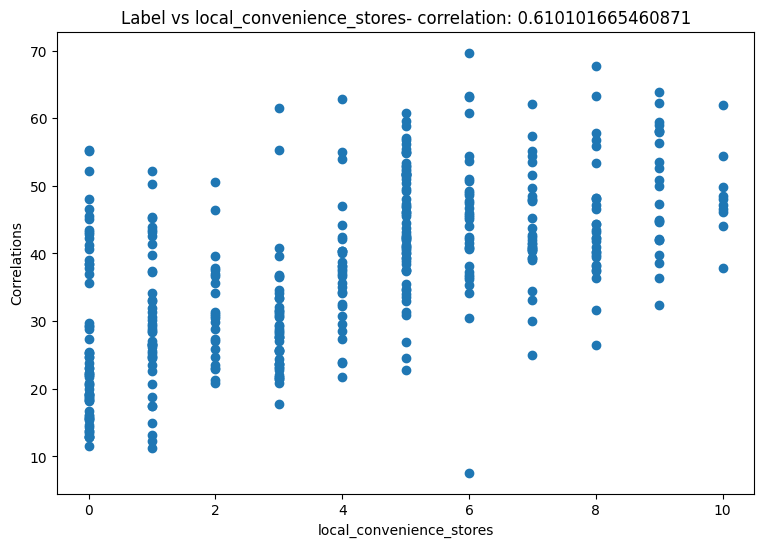

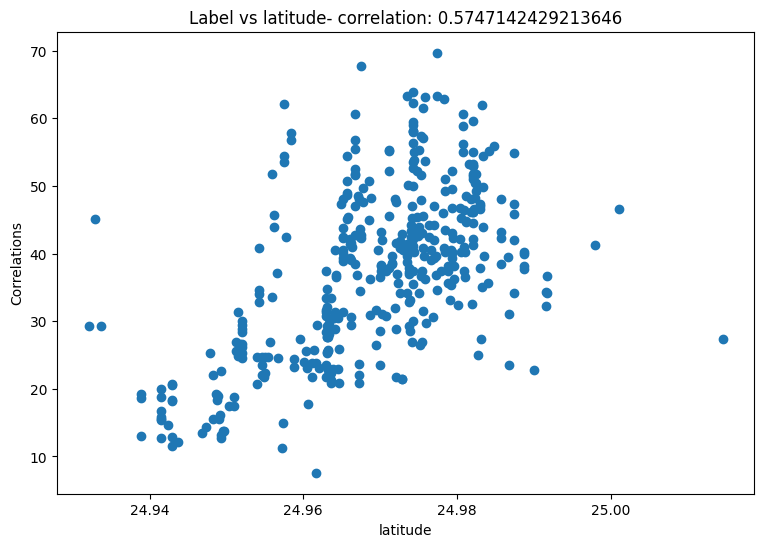

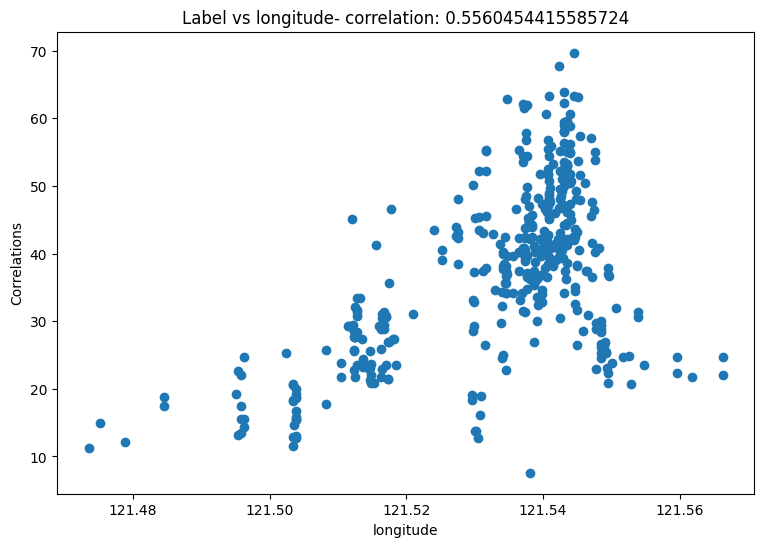

In [4]:
for col in data[data.columns[0:-1]]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = data[col]
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Correlations')
    ax.set_title('Label vs ' + col + '- correlation: ' + str(correlation))
plt.show()


### View categorical features

(**transaction_date** and **local_convenience_stores** seem to be discrete values, so might work better if treated as categorical features)

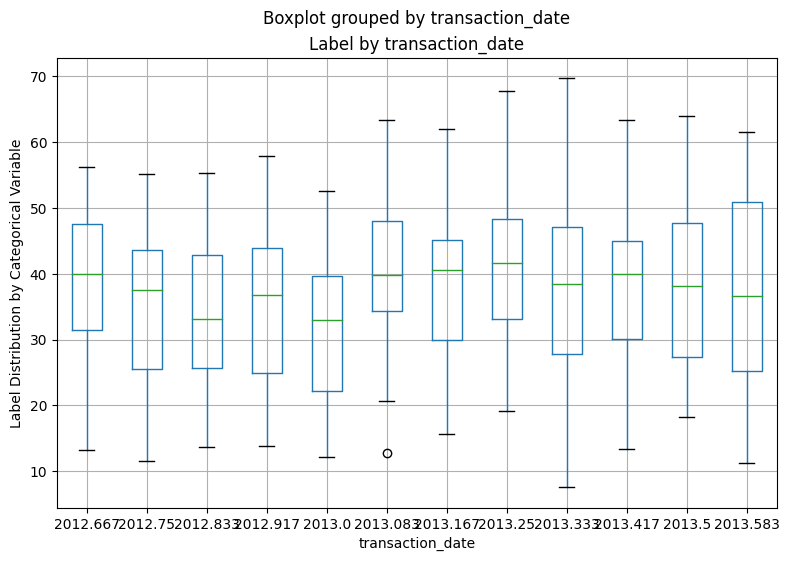

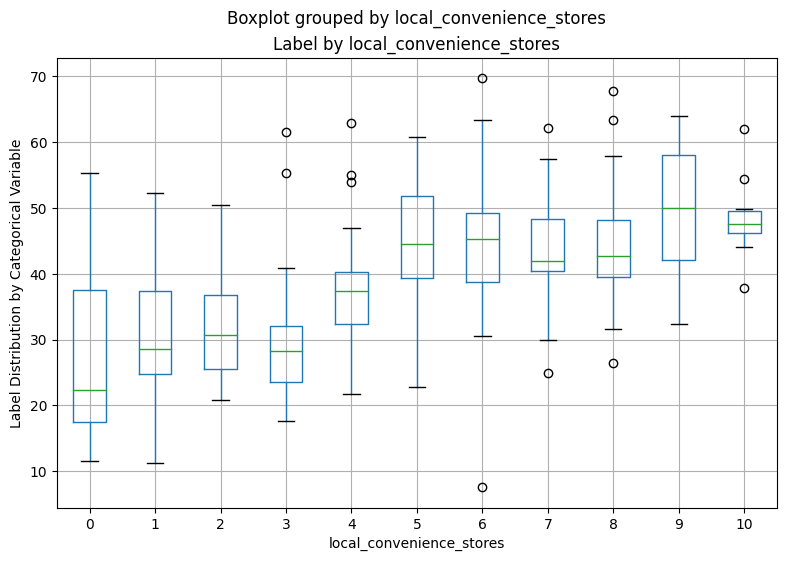

In [5]:
# plot a boxplot for the label by each categorical feature
for col in data[['transaction_date', 'local_convenience_stores']]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    data.boxplot(column = 'price_per_unit', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Label Distribution by Categorical Variable")
plt.show()

### Separate features and label and split data for training and validation

(**transaction_date** doesn't seem to be very predictive, so omit it)

In [6]:
from sklearn.model_selection import train_test_split

# Separate features (columns 1 [house_age] to the last but one) and labels (the last column)
X, y = data[data.columns[1:-1]].values, data[data.columns[-1]].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d, rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 285, rows
Test Set: 123 rows


### Preprocess the data and train a model in a pipeline

Normalize the numeric features, then use a RandomForestRegressor to train a model.

In [7]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [0,1,3,4]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 4])])),
                ('regressor', RandomForestRegressor())])


### Evaluate the model

MSE: 36.436148319872515
RMSE: 6.036236271044443
R2: 0.6890887005948578


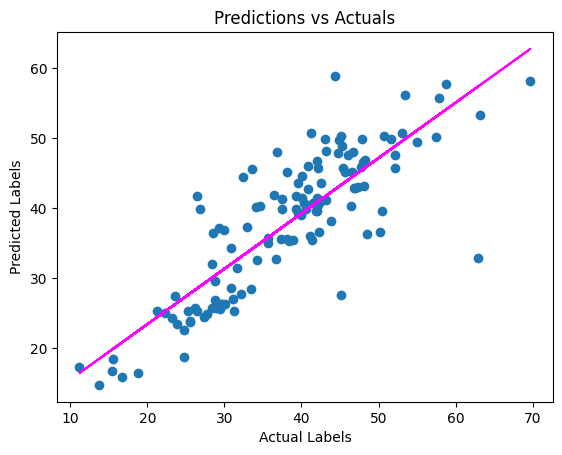

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predictions vs Actuals')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

## Use the Trained Model

Save your trained model, and then use it to predict the price-per-unit for the following real estate transactions:

| transaction_date | house_age | transit_distance | local_convenience_stores | latitude | longitude |
| ---------------- | --------- | ---------------- | ------------------------ | -------- | --------- |
|2013.167|16.2|289.3248|5|24.98203|121.54348|
|2013.000|13.6|4082.015|0|24.94155|121.50381|

In [9]:
import joblib

# Save the model as a pickle file
filename = './models/real_estate_model.pkl'
joblib.dump(model, filename)

# Load the model from the file
loaded_model = joblib.load(filename)

# An array of features for each transaction (don't include the transaction date)
X_new = np.array([[16.2,289.3248,5,24.98203,121.54348],
                  [13.6,4082.015,0,24.94155,121.5038]])

# Use the model to predict unit price
results = loaded_model.predict(X_new)
print('Predictions:')
for prediction in results:
    print(round(prediction,2))

Predictions:
49.41
16.72
